------------------------------
Semidefinite Program
  maximize ⟨L, X⟩
  over
    20×20 symmetric variable X
  subject to
    maindiag(X) = [1]
    X ≽ 0
------------------------------
bound from the SDP relaxation: 27.63030241884881


Text(0.5, 0.97, 'SDP relaxation value: 27.6\nCut value: 26.0 = 0.941×27.6')

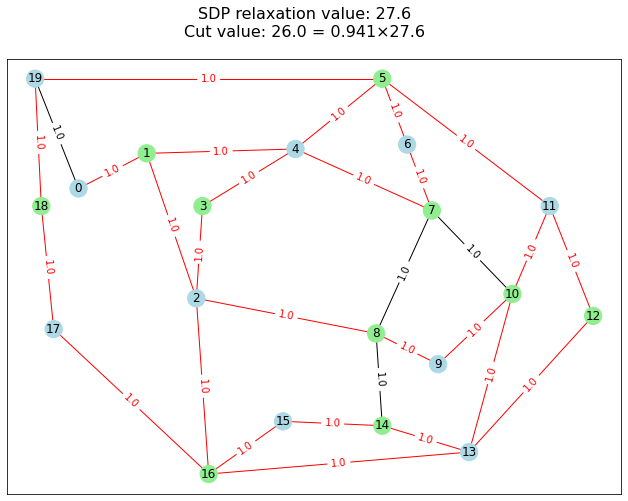

In [7]:
import cvxopt as cvx
import cvxopt.lapack
import numpy as np
import picos as pic
import networkx as nx
import pylab
import random
import warnings

warnings.filterwarnings('ignore')
# Use a fixed RNG seed so the result is reproducable.
random.seed(1)

# Number of nodes.
N=20

# Generate a graph using LCF notation.
G=nx.LCF_graph(N,[1,3,14],5)
G=nx.DiGraph(G) #edges are bidirected

# Generate edge capacities.
c={}
for e in sorted(G.edges(data=True)):
  capacity = 0.5
  e[2]['capacity'] = capacity
  c[(e[0], e[1])]  = capacity

# Convert the capacities to a PICOS expression.
cc=pic.new_param('c',c)
# picosの初期配置
pos={
  0:  (0.07, 0.70), 1:  (0.18, 0.78), 2:  (0.26, 0.45), 3:  (0.27, 0.66),
  4:  (0.42, 0.79), 5:  (0.56, 0.95), 6:  (0.60, 0.80), 7:  (0.64, 0.65),
  8:  (0.55, 0.37), 9:  (0.65, 0.30), 10: (0.77, 0.46), 11: (0.83, 0.66),
  12: (0.90, 0.41), 13: (0.70, 0.10), 14: (0.56, 0.16), 15: (0.40, 0.17),
  16: (0.28, 0.05), 17: (0.03, 0.38), 18: (0.01, 0.66), 19: (0.00, 0.95)
}
# 円周上に座標配置
# pos = {
#         n: (np.cos(2*i*np.pi/N), np.sin(2*i*np.pi/N))
#         for i, n in enumerate(G.nodes)
#     }

# randomに座標設定
# pos = nx.random_layout(G)

# Define a plotting helper that closes the old and opens a new figure.
def new_figure():
  try:
    global fig
    pylab.close(fig)
  except NameError:
    pass
  fig=pylab.figure(figsize=(11,8))
  fig.gca().axes.get_xaxis().set_ticks([])
  fig.gca().axes.get_yaxis().set_ticks([])


# Make G undirected.
G=nx.Graph(G)

# Allocate weights to the edges.
for (i,j) in G.edges():
  G[i][j]['weight']=c[i,j]+c[j,i]

maxcut = pic.Problem()

# Add the symmetric matrix variable.
X=maxcut.add_variable('X', (N,N), 'symmetric')

# Retrieve the Laplacian of the graph.
LL = 1/4.*nx.laplacian_matrix(G).todense()
L=pic.new_param('L', LL)

# Constrain X to have ones on the diagonal.
maxcut.add_constraint(pic.diag_vect(X) == 1)

# Constrain X to be positive semidefinite.
maxcut.add_constraint(X >> 0)

# Set the objective.
maxcut.set_objective('max', L|X)

print(maxcut)

# Solve the problem.
maxcut.solve(solver='cvxopt')

print('bound from the SDP relaxation: {0}'.format(maxcut.obj_value()))

# Use a fixed RNG seed so the result is reproducable.
cvx.setseed(1)

# Perform a Cholesky factorization.
V=X.value
cvxopt.lapack.potrf(V)
for i in range(N):
  for j in range(i+1,N):
    V[i,j]=0

# Do up to 100 projections. Stop if we are within a factor 0.878 of the SDP
# optimal value.
count=0
obj_sdp=maxcut.obj_value()
obj=0
while (count < 100 or obj < 0.878*obj_sdp):
  r=cvx.normal(20,1)
  x=cvx.matrix(np.sign(V*r))
  o=(x.T*L*x).value
  if o > obj:
    x_cut=x
    obj=o
  count+=1
x=x_cut

# Extract the cut and the seperated node sets.
S1=[n for n in range(N) if x[n]<0]
S2=[n for n in range(N) if x[n]>0]
cut = [(i,j) for (i,j) in G.edges() if x[i]*x[j]<0]
leave = [e for e in G.edges if e not in cut]

# Close the old figure and open a new one.
new_figure()

# Assign colors based on set membership.
node_colors=[('lightgreen' if n in S1 else 'lightblue') for n in range(N)]

# Draw the nodes and the edges that are not in the cut.
nx.draw_networkx(G, pos, node_color=node_colors, edgelist=leave)
labels={e: '{}'.format(G[e[0]][e[1]]['weight']) for e in leave}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Draw the edges that are in the cut.
nx.draw_networkx_edges(G, pos, edgelist=cut, edge_color='r')
labels={e: '{}'.format(G[e[0]][e[1]]['weight']) for e in cut}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='r')

# Show the relaxation optimum value and the cut capacity.
rval = maxcut.obj_value()
sval = sum(G[e[0]][e[1]]['weight'] for e in cut)
fig.suptitle(
  'SDP relaxation value: {0:.1f}\nCut value: {1:.1f} = {2:.3f}×{0:.1f}'
  .format(rval, sval, sval/rval), fontsize=16, y=0.97)

### with LCF_graph

--------------------------------
Semidefinite Program
  maximize ⟨L, X⟩
  over
    100×100 symmetric variable X
  subject to
    maindiag(X) = [1]
    X ≽ 0
--------------------------------


Text(0.5, 0.97, 'SDP relaxation value: 245.9\nCut value: 232.0 = 0.944×245.9\n elapsed_time171.1640')

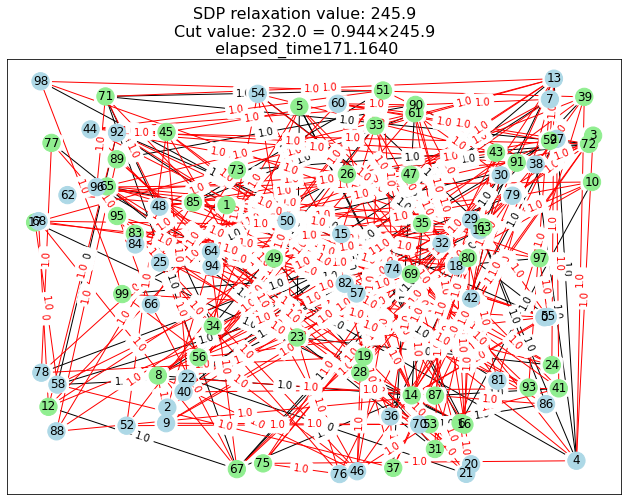

In [9]:
import cvxopt as cvx
import cvxopt.lapack
import numpy as np
import picos as pic
import networkx as nx
import pylab
import random
import time
import warnings

warnings.filterwarnings('ignore')

# Use a fixed RNG seed so the result is reproducable.
random.seed(1)

# Number of nodes.
N=100

# # Add edges to the graph (also adds nodes)

G=nx.LCF_graph(N,[0,0],int(N/2))
G.add_edges_from([(0, 14), (0, 85), (0, 92), (1, 78), (2, 26), (2, 33), (3, 46), (3, 36), (3, 79), (4, 11), (4, 13), (4, 38), (4, 75), (4, 96), (4, 39), (4, 45), (5, 40), (5, 64), (5, 23), (5, 16), (5, 18), (6, 21), (6, 10), (6, 84), (7, 47), (7, 15), (7, 90), (7, 8), (7, 93), (8, 46), (8, 59), (8, 29), (8, 14), (8, 15), (9, 69), (9, 16), (10, 96), (10, 64), (11, 22), (11, 86), (11, 90), (12, 67), (12, 92), (12, 60), (12, 68), (13, 59), (13, 71), (13, 33), (13, 17), (13, 47), (13, 36), (13, 28), (13, 24), (13, 40), (14, 55), (14, 35), (14, 42), (14, 29), (14, 67), (14, 60), (15, 33), (15, 80), (15, 57), (16, 36), (16, 53), (16, 29), (16, 42), (16, 18), (16, 28), (17, 58), (18, 67), (18, 90), (18, 87), (18, 19), (19, 64), (19, 78), (19, 36), (20, 61), (20, 65), (20, 89), (21, 33), (21, 89), (21, 53), (21, 87), (22, 61), (22, 58), (22, 82), (22, 87), (22, 45), (22, 80), (23, 74), (23, 57), (23, 76), (23, 44), (23, 54), (23, 24), (24, 44), (24, 74), (25, 56), (25, 39), (26, 44), (26, 99), (26, 72), (26, 81), (27, 56), (27, 87), (27, 41), (27, 42), (28, 46), (29, 65), (29, 69), (30, 69), (30, 42), (30, 61), (30, 75), (31, 77), (31, 49), (32, 34), (32, 75), (32, 72), (32, 47), (33, 51), (33, 63), (34, 96), (34, 88), (34, 54), (34, 71), (35, 96), (35, 60), (37, 82), (37, 79), (37, 58), (37, 61), (38, 50), (38, 51), (38, 72), (39, 81), (39, 98), (39, 67), (41, 87), (41, 74), (41, 70), (42, 61), (43, 70), (43, 54), (43, 76), (43, 48), (44, 90), (44, 51), (45, 52), (45, 50), (45, 60), (45, 92), (46, 53), (46, 99), (46, 51), (46, 83), (48, 71), (48, 73), (49, 82), (50, 57), (51, 74), (51, 85), (51, 71), (53, 57), (54, 80), (55, 65), (55, 97), (55, 63), (57, 69), (57, 93), (58, 92), (60, 72), (60, 90), (61, 85), (62, 91), (63, 68), (63, 94), (63, 84), (65, 80), (66, 73), (67, 69), (67, 94), (67, 71), (67, 79), (69, 86), (69, 92), (70, 86), (70, 83), (71, 96), (72, 84), (72, 92), (74, 98), (79, 83), (80, 94), (82, 92), (82, 95), (84, 85), (85, 88), (97, 99)])# ------- Set up our QUBO dictionary -------
G=nx.DiGraph(G) #edges are bidirected

# Generate edge capacities.
c={}
for e in sorted(G.edges(data=True)):
  capacity = 0.5
  e[2]['capacity'] = capacity
  c[(e[0], e[1])]  = capacity

# Convert the capacities to a PICOS expression.
cc=pic.new_param('c',c)

# 円周上に座標配置
# pos = {
#         n: (np.cos(2*i*np.pi/N), np.sin(2*i*np.pi/N))
#         for i, n in enumerate(G.nodes)
#     }
# randomに座標設定
pos = nx.random_layout(G)
# picosの初期配置
# pos={
#   0:  (0.07, 0.70), 1:  (0.18, 0.78), 2:  (0.26, 0.45), 3:  (0.27, 0.66),
#   4:  (0.42, 0.79), 5:  (0.56, 0.95), 6:  (0.60, 0.80), 7:  (0.64, 0.65),
#   8:  (0.55, 0.37), 9:  (0.65, 0.30), 10: (0.77, 0.46), 11: (0.83, 0.66),
#   12: (0.90, 0.41), 13: (0.70, 0.10), 14: (0.56, 0.16), 15: (0.40, 0.17),
#   16: (0.28, 0.05), 17: (0.03, 0.38), 18: (0.01, 0.66), 19: (0.00, 0.95)
# }


# Define a plotting helper that closes the old and opens a new figure.
def new_figure():
  try:
    global fig
    pylab.close(fig)
  except NameError:
    pass
  fig=pylab.figure(figsize=(11,8))
  fig.gca().axes.get_xaxis().set_ticks([])
  fig.gca().axes.get_yaxis().set_ticks([])

# Make G undirected.
G=nx.Graph(G)

# Allocate weights to the edges.
for (i,j) in G.edges():
  G[i][j]['weight']=c[i,j]+c[j,i]

maxcut = pic.Problem()

# Add the symmetric matrix variable.
X=maxcut.add_variable('X', (N,N), 'symmetric')

# Retrieve the Laplacian of the graph.
LL = 1/4.*nx.laplacian_matrix(G).todense()
L=pic.new_param('L', LL)

# Constrain X to have ones on the diagonal.
maxcut.add_constraint(pic.diag_vect(X) == 1)

# Constrain X to be positive semidefinite.
maxcut.add_constraint(X >> 0)

# Set the objective.
maxcut.set_objective('max', L|X)

print(maxcut)

# Solve the problem.
start = time.time()
maxcut.solve(solver='cvxopt')
elapsed_time = time.time() - start

#print('bound from the SDP relaxation: {0}'.format(maxcut.obj_value()))

# Use a fixed RNG seed so the result is reproducable.
cvx.setseed(1)

# Perform a Cholesky factorization.
V=X.value
cvxopt.lapack.potrf(V)
for i in range(N):
  for j in range(i+1,N):
    V[i,j]=0

# Do up to 100 projections. Stop if we are within a factor 0.878 of the SDP
# optimal value.
count=0
obj_sdp=maxcut.obj_value()
obj=0
while (count < 100 or obj < 0.878*obj_sdp):
  r=cvx.normal(N,1)
  x=cvx.matrix(np.sign(V*r))
  o=(x.T*L*x).value
  if o > obj:
    x_cut=x
    obj=o
  count+=1
x=x_cut

# Extract the cut and the seperated node sets.
S1=[n for n in range(N) if x[n]<0]
S2=[n for n in range(N) if x[n]>0]
cut = [(i,j) for (i,j) in G.edges() if x[i]*x[j]<0]
leave = [e for e in G.edges if e not in cut]

# Close the old figure and open a new one.
new_figure()

# Assign colors based on set membership.
node_colors=[('lightgreen' if n in S1 else 'lightblue') for n in range(N)]

# Draw the nodes and the edges that are not in the cut.
nx.draw_networkx(G, pos, node_color=node_colors, edgelist=leave)
labels={e: '{}'.format(G[e[0]][e[1]]['weight']) for e in leave}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Draw the edges that are in the cut.
nx.draw_networkx_edges(G, pos, edgelist=cut, edge_color='r')
labels={e: '{}'.format(G[e[0]][e[1]]['weight']) for e in cut}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='r')

# Show the relaxation optimum value and the cut capacity.
rval = maxcut.obj_value()
sval = sum(G[e[0]][e[1]]['weight'] for e in cut)
fig.suptitle(
  'SDP relaxation value: {0:.1f}\nCut value: {1:.1f} = {2:.3f}×{0:.1f}\n elapsed_time{3:.4f}'
  .format(rval, sval, sval/rval,elapsed_time), fontsize=16, y=0.97)

### with other graph

In [ ]:
G = nx.Graph()
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)]) 
 nx.draw_networkx(G)   
G = nx.path_graph(4)
nx.draw_networkx(G)  

In [24]:
 G = nx.lollipop_graph(4, 3)


In [25]:
print(G)